In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from itertools import islice
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import get_window

In [3]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_44KHz/train'
CSV = DATA/'freesound/audio_44KHz/train.csv'

df = pd.read_csv(CSV)
df.head(3)

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0


In [4]:
row = df.iloc[1] # saxophone clip
filename = AUDIO / row.fname

# open the audio file
clip, sample_rate = librosa.load(filename, sr=None)

print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(clip)/sample_rate))

Sample Rate   44100 Hz
Clip Length   10.32 seconds


In [5]:
three_seconds = sample_rate * 3
clip = clip[:three_seconds]

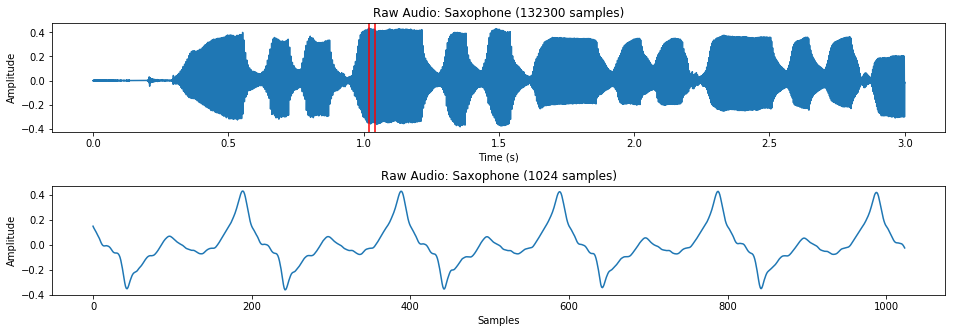

In [6]:
timesteps = np.arange(len(clip)) / sample_rate  # in seconds

fig, ax = plt.subplots(2, figsize=(16, 5))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip 
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} ({} samples)'.format(row.label, len(clip)))


n_fft = 1024 # frame length 
start = 45000 # start at a part of the sound thats not silence.. 
x = clip[start:start+n_fft]

# mark location of frame in the entire signal
ax[0].axvline(start/sample_rate, c='r') 
ax[0].axvline((start+n_fft)/sample_rate, c='r')

# plot N samples 
ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Raw Audio: {} ({} samples)'.format(row.label, len(x)));

In [7]:
Audio(clip, rate=sample_rate)

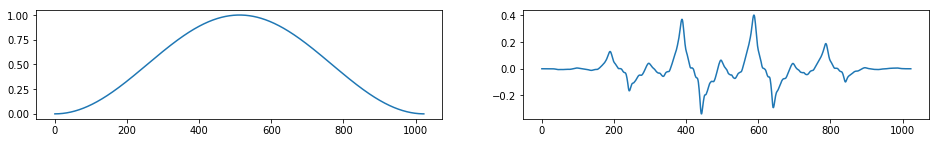

In [8]:
window = get_window('hann', n_fft)
wx = x * window

fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].plot(window)
ax[1].plot(wx);

In [9]:
# Compute (real) FFT on window
X = fft(x, n_fft)
X.shape, X.dtype

((1024,), dtype('complex64'))

((513,), dtype('float32'))

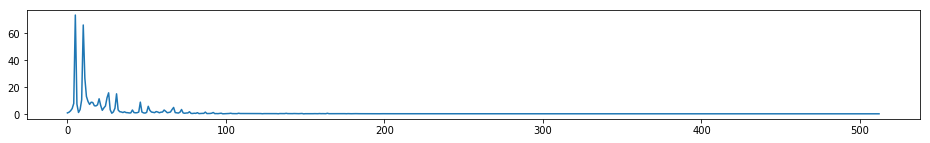

In [10]:
# We only use the first (n_fft/2)+1 numbers of the output, as the second half if redundant
X = X[:n_fft//2+1]

# Convert from rectangular to polar, usually only care about magnitude
X_magnitude, X_phase = librosa.magphase(X)

plt.figure(figsize=(16, 2))
plt.plot(X_magnitude);

X_magnitude.shape, X_magnitude.dtype

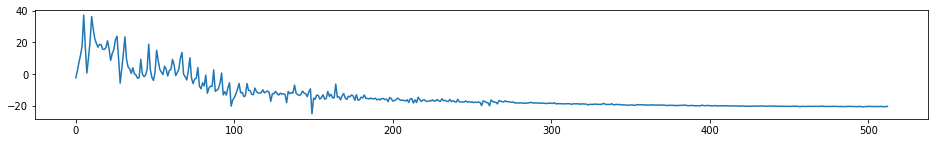

In [11]:
# we hear loudness in decibels (on a log scale of amplitude)
X_magnitude_db = librosa.amplitude_to_db(X_magnitude)

plt.figure(figsize=(16, 2))
plt.plot(X_magnitude_db);

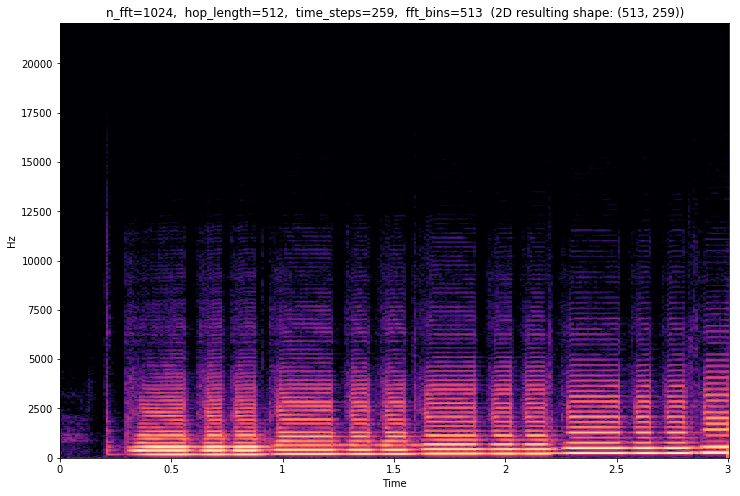

In [12]:
hop_length = 512
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

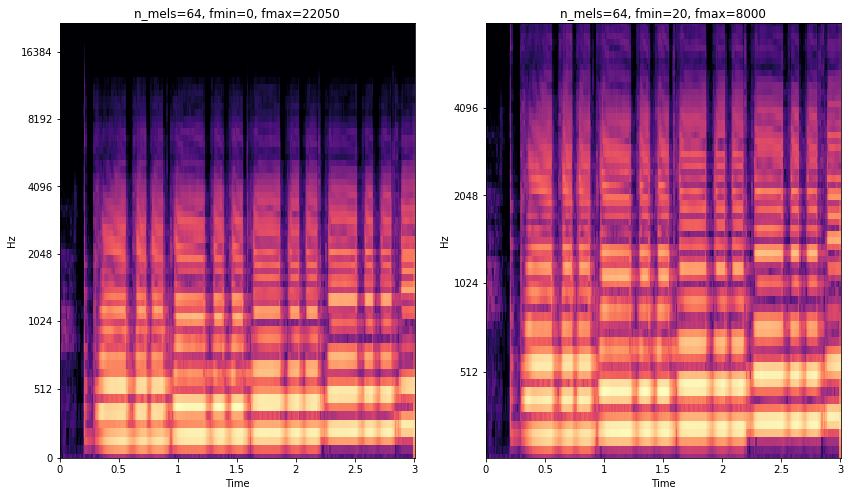

In [22]:
# number of mel frequency bands 
n_mels = 64

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

fmin = 0            
fmax = 22050 # sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title('n_mels=64, fmin=0, fmax=22050')

fmin = 20           
fmax = 8000
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title('n_mels=64, fmin=20, fmax=8000')

plt.show()